# **MRI Brain Alzheimer Classification - Naive Model**

**Clone Dataset from GitHub**

In [1]:
# Check if the directory exists and clone if it does not
# !if [ ! -d "MRI_Brain_Alzheimer_Classification" ]; then git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification; fi

# Change directory to the cloned repository
# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


**Install Packages**

In [2]:
!pip show kornia || pip install kornia
!pip show optuna || pip install optuna
!pip show tqdm || pip install tqdm

Name: kornia
Version: 0.7.3
Summary: Open Source Differentiable Computer Vision Library for PyTorch
Home-page: 
Author: 
Author-email: Edgar Riba <edgar@kornia.org>
License: Apache-2.0
Location: c:\downloads\anaconda\anaconda\envs\deep_learn\lib\site-packages
Requires: kornia-rs, packaging, torch
Required-by: 
Name: optuna
Version: 3.6.1
Summary: A hyperparameter optimization framework
Home-page: 
Author: Takuya Akiba
Author-email: 
License: MIT License
        
        Copyright (c) 2018 Preferred Networks, Inc.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following con

**Import Packages**

In [3]:
# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time

# repository imports
from models import def_models
from utils import utils_funcs
from utils import optuna_search

c:\downloads\anaconda\Anaconda\envs\deep_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Device Definition**

In [4]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


**Load the Dataset**

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')

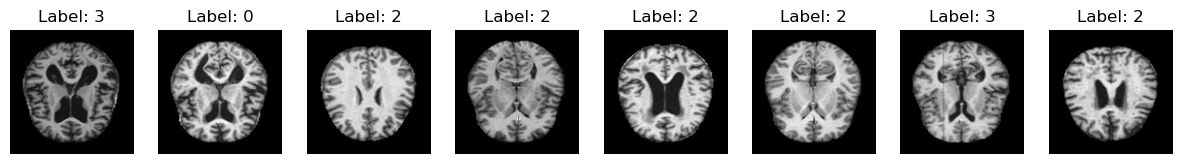

In [6]:
# Get 8 unique random train indices
random_indices = random.sample(range(len(train_set)), 8)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    image, label = train_set[idx]
    image = image.permute(1, 2, 0)
    plt.subplot(1, 8, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

**Naive Model Definition and Initialization**

In [7]:
# Initialize the model
input_channels = 3
output_channels = 4
model = def_models.NaiveModel(input_channels, output_channels).to(device)

**Optuna**

In [8]:
params = optuna_search.optuna_param_search(model_name="NaiveModel", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=1, device='cpu')
print(params)

[I 2024-08-15 21:23:26,750] A new study created in memory with name: mri-alzhimer-classification
100%|██████████| 1/1 [06:44<00:00, 404.75s/it]
[I 2024-08-15 21:30:12,129] Trial 0 finished with value: 0.49375 and parameters: {'lr': 0.00040045013056785536, 'optimizer': 'RMSprop', 'batch_size': 32}. Best is trial 0 with value: 0.49375.
100%|██████████| 1/1 [03:45<00:00, 225.20s/it]
[I 2024-08-15 21:33:57,919] Trial 1 finished with value: 0.4791666666666667 and parameters: {'lr': 0.00014461297955698985, 'optimizer': 'RMSprop', 'batch_size': 16}. Best is trial 0 with value: 0.49375.
100%|██████████| 1/1 [02:08<00:00, 128.10s/it]
[I 2024-08-15 21:36:06,609] Trial 2 finished with value: 0.4 and parameters: {'lr': 0.024379650583247946, 'optimizer': 'SGD', 'batch_size': 8}. Best is trial 0 with value: 0.49375.


Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  0.49375
  Params: 
    lr: 0.00040045013056785536
    optimizer: RMSprop
    batch_size: 32
{'lr': 0.00040045013056785536, 'optimizer': 'RMSprop', 'batch_size': 32}


**Hyper-Parameters**

In [9]:
# Hyper-parameters
batch_size = params['batch_size']
learning_rate = params['lr']
optimizer_name = params['optimizer']
num_epochs = 60

# loss criterion
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)

# Combine train_set and val_set into one dataset and
combined_train_val_set = ConcatDataset([train_set, validation_set])

# Loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(combined_train_val_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


**Train Model**

In [8]:
epoch_losses = utils_funcs.train(model, num_epochs, trainloader, device, criterion, optimizer)

Epoch: 1 | Loss: 1.0789 | Training accuracy: 35.290% | Epoch Time: 26.41 secs
Epoch: 2 | Loss: 1.0460 | Training accuracy: 49.554% | Epoch Time: 24.73 secs
Epoch: 3 | Loss: 1.0223 | Training accuracy: 50.223% | Epoch Time: 25.06 secs
Epoch: 4 | Loss: 0.9942 | Training accuracy: 50.915% | Epoch Time: 25.36 secs
Epoch: 5 | Loss: 0.9481 | Training accuracy: 53.192% | Epoch Time: 25.55 secs
Epoch: 6 | Loss: 0.9355 | Training accuracy: 51.295% | Epoch Time: 25.51 secs
Epoch: 7 | Loss: 0.9308 | Training accuracy: 51.250% | Epoch Time: 25.35 secs
Epoch: 8 | Loss: 0.9275 | Training accuracy: 53.348% | Epoch Time: 25.41 secs
Epoch: 9 | Loss: 0.9346 | Training accuracy: 53.862% | Epoch Time: 25.51 secs
Epoch: 10 | Loss: 0.9301 | Training accuracy: 52.746% | Epoch Time: 25.55 secs
Epoch: 11 | Loss: 0.9125 | Training accuracy: 53.772% | Epoch Time: 25.46 secs
Epoch: 12 | Loss: 0.9200 | Training accuracy: 52.612% | Epoch Time: 25.45 secs
Epoch: 13 | Loss: 0.9152 | Training accuracy: 53.571% | Epoch

**Results**

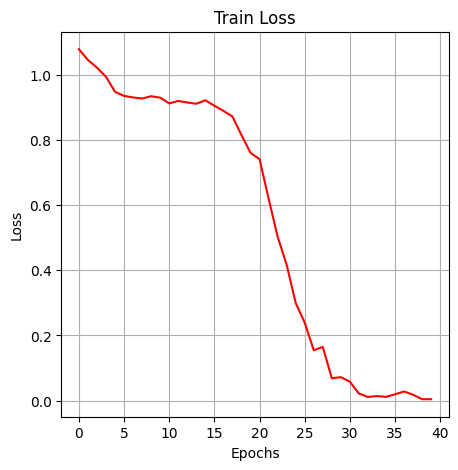

In [9]:
utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

In [10]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 97.969%


**Adding a Noise**

In [20]:
noise = 0.1
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        image_n = images + noise * torch.randn(images.size())
        image_n = image_n.to(device)
        labels = labels.to(device)
        outputs = model(image_n)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test accuracy with a noise: {accuracy:.3f}%")

Test accuracy with a noise: 86.875%
